# XGBoost Relationship Analysis

#### Mean Squared Error (MSE) = difference between predicted and observed values - lower results indicate better results and that sentiment is a useful predictor
#### Alpha = degree of exponential smoothing - 0 means no and 1 means highest possible smoothing

Sentiment: VADER Sentiment, Return: Technology Return, Time Lag: 1, Alpha: 0.5, MSE: 0.0003, MAE: 0.0132, R2: -0.5360, RMSE: 0.0163
Sentiment: VADER Sentiment, Return: Technology Return, Time Lag: 2, Alpha: 0.5, MSE: 0.0003, MAE: 0.0142, R2: -0.7861, RMSE: 0.0174
Sentiment: VADER Sentiment, Return: Technology Return, Time Lag: 3, Alpha: 0.5, MSE: 0.0003, MAE: 0.0138, R2: -0.7607, RMSE: 0.0171
Sentiment: VADER Sentiment, Return: Technology Return, Time Lag: 4, Alpha: 0.5, MSE: 0.0003, MAE: 0.0138, R2: -0.7201, RMSE: 0.0170
Sentiment: VADER Sentiment, Return: Technology Return, Time Lag: 5, Alpha: 0.5, MSE: 0.0003, MAE: 0.0143, R2: -0.8129, RMSE: 0.0175
Sentiment: VADER Sentiment, Return: Financials Return, Time Lag: 1, Alpha: 0.5, MSE: 0.0003, MAE: 0.0134, R2: -0.9792, RMSE: 0.0168
Sentiment: VADER Sentiment, Return: Financials Return, Time Lag: 2, Alpha: 0.5, MSE: 0.0003, MAE: 0.0140, R2: -0.9691, RMSE: 0.0170
Sentiment: VADER Sentiment, Return: Financials Return, Time Lag: 3, Alpha: 0

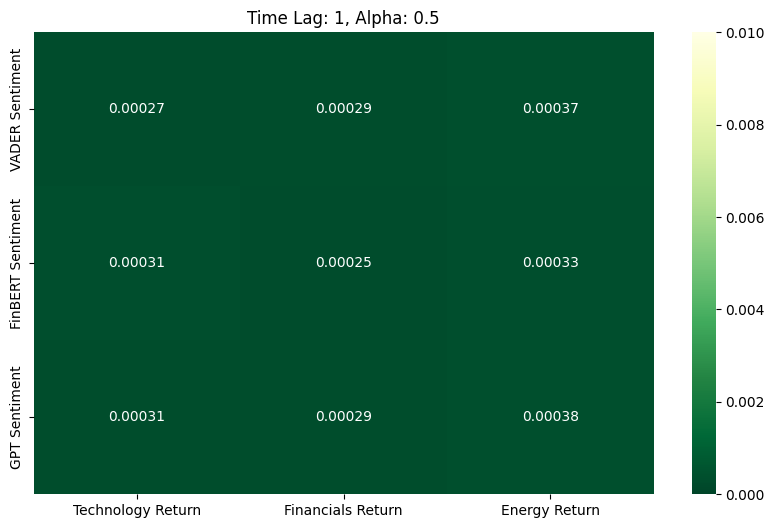

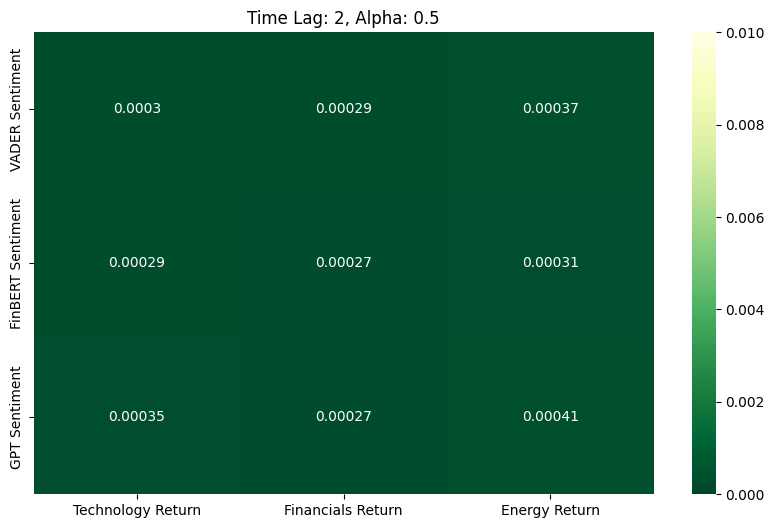

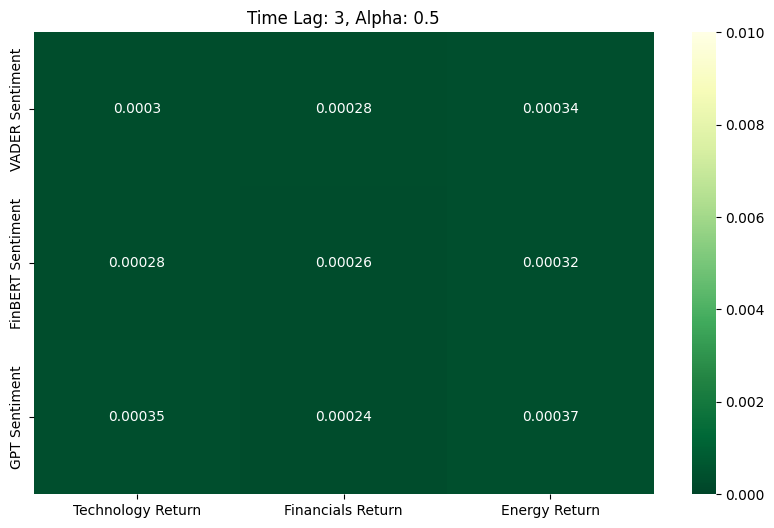

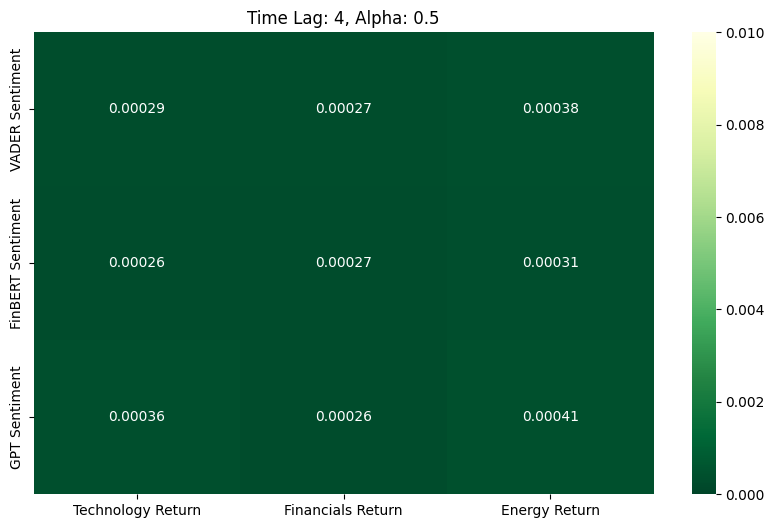

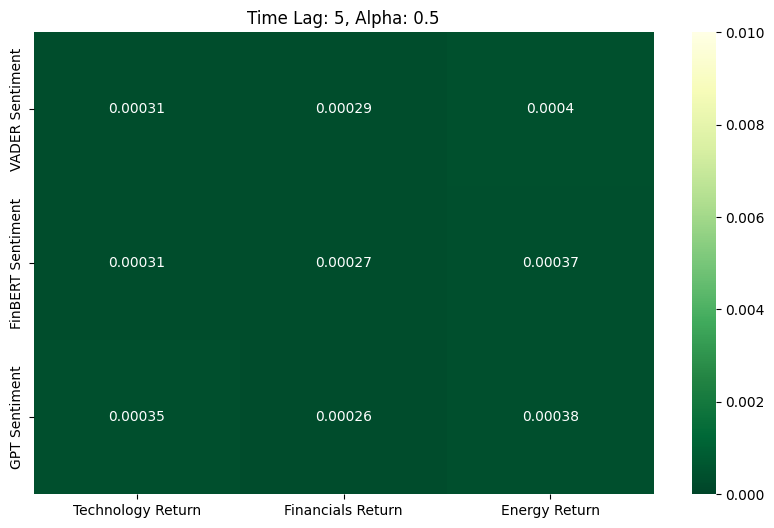

In [29]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize dictionaries to store the results for the new metrics
results = {}
mae_results = {}
r2_results = {}
rmse_results = {}

# Load data
sentiment_data_financials = pd.read_csv('Sentiment_Results_Financials_Sum.csv')
sentiment_data_energy = pd.read_csv('Sentiment_Results_Energy_Sum.csv')
sentiment_data_technology = pd.read_csv('Sentiment_Results_Technology_Sum.csv')
returns_data = pd.read_csv('Portfolio_Returns_Linear.csv')

# Merge datasets on Date, and only keep rows where both Sentiment and Return data are available
merged_data_financials = pd.merge(sentiment_data_financials, returns_data[['Date', 'Financials Return']], on='Date')
merged_data_energy = pd.merge(sentiment_data_energy, returns_data[['Date', 'Energy Return']], on='Date')
merged_data_technology = pd.merge(sentiment_data_technology, returns_data[['Date', 'Technology Return']], on='Date')

# Define the sentiments and returns
sentiments = ['VADER Sentiment', 'FinBERT Sentiment', 'GPT Sentiment']
returns = ['Technology Return', 'Financials Return', 'Energy Return']

# Festlegung des Alpha-Wertes
alpha = 0.5  # Hier kannst du den Wert einstellen

# Funktion für die exponentielle Glättung
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

# Schleife durch Sentiments und Returns
for sentiment in sentiments:
    for ret in returns:
        for timelag in range(1, 6):
            
            # Select the appropriate merged_data based on the return type
            if ret == 'Technology Return':
                merged_data = merged_data_technology
            elif ret == 'Financials Return':
                merged_data = merged_data_financials
            else:  # 'Energy Return'
                merged_data = merged_data_energy
            
            # Verschiebung der Renditen um den Time Lag
            lagged_returns = merged_data[ret].shift(timelag).dropna().values
            
            # Apply exponential smoothing to the lagged returns
            smoothed_returns = exponential_smoothing(lagged_returns, alpha)

            # Schneiden des Sentiments entsprechend des Time Lags und Konvertierung in eine Liste
            aligned_sentiments = merged_data[sentiment].iloc[timelag:].tolist()

            smoothed_sentiments = exponential_smoothing(aligned_sentiments, alpha)

            X = np.array(smoothed_sentiments).reshape(-1, 1)
            y = np.array(smoothed_returns).reshape(-1, 1)  # Use the smoothed returns as the target variable

            tscv = TimeSeriesSplit(n_splits=5)

            scores = []
            for train_index, test_index in tscv.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                model = xgb.XGBRegressor(objective='reg:squarederror')
                model.fit(X_train, y_train)
                predictions = model.predict(X_test)
                mse_score = mean_squared_error(y_test, predictions)
                mae_score = mean_absolute_error(y_test, predictions)
                r2_score_value = r2_score(y_test, predictions)
                rmse_score = np.sqrt(mse_score)
                scores.append((mse_score, mae_score, r2_score_value, rmse_score))

            avg_mse, avg_mae, avg_r2, avg_rmse = np.mean(scores, axis=0)

            print(f"Sentiment: {sentiment}, Return: {ret}, Time Lag: {timelag}, Alpha: {alpha}, MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}, R2: {avg_r2:.4f}, RMSE: {avg_rmse:.4f}")

            # Update the results dictionaries
            key = (sentiment, ret, timelag, alpha)
            results[key] = avg_mse
            mae_results[key] = avg_mae
            r2_results[key] = avg_r2
            rmse_results[key] = avg_rmse


# Now let's plot the results as heatmaps
for timelag in range(1, 6):
    # Prepare the data for heatmap
    matrix_data = pd.DataFrame(index=sentiments, columns=returns)
    for sentiment in sentiments:
        for ret in returns:
            key = (sentiment, ret, timelag, alpha)
            matrix_data.loc[sentiment, ret] = results[key]

    plt.figure(figsize=(10, 6))
    
    # Use vmin and vmax to set the scale, and choose "YlGn" as the colormap
    sns.heatmap(matrix_data.astype(float), annot=True, cmap="YlGn_r", vmin=0, vmax=0.01)
    plt.title(f"Time Lag: {timelag}, Alpha: {alpha}")
    plt.show()




Sentiment: VADER Sentiment, Return: Technology Return, Time Lag: 1, Alpha: 0.5, MSE: 0.0001, MAE: 0.0085, R2: -0.3654, RMSE: 0.0104
Sentiment: VADER Sentiment, Return: Technology Return, Time Lag: 2, Alpha: 0.5, MSE: 0.0001, MAE: 0.0085, R2: -0.3617, RMSE: 0.0104
Sentiment: VADER Sentiment, Return: Technology Return, Time Lag: 3, Alpha: 0.5, MSE: 0.0001, MAE: 0.0088, R2: -0.4270, RMSE: 0.0107
Sentiment: VADER Sentiment, Return: Technology Return, Time Lag: 4, Alpha: 0.5, MSE: 0.0001, MAE: 0.0091, R2: -0.5852, RMSE: 0.0112
Sentiment: VADER Sentiment, Return: Technology Return, Time Lag: 5, Alpha: 0.5, MSE: 0.0001, MAE: 0.0092, R2: -0.6658, RMSE: 0.0114
Sentiment: VADER Sentiment, Return: Technology Return, Time Lag: 6, Alpha: 0.5, MSE: 0.0001, MAE: 0.0095, R2: -0.7551, RMSE: 0.0116
Sentiment: VADER Sentiment, Return: Technology Return, Time Lag: 7, Alpha: 0.5, MSE: 0.0001, MAE: 0.0094, R2: -0.7257, RMSE: 0.0114
Sentiment: VADER Sentiment, Return: Technology Return, Time Lag: 8, Alpha: 0

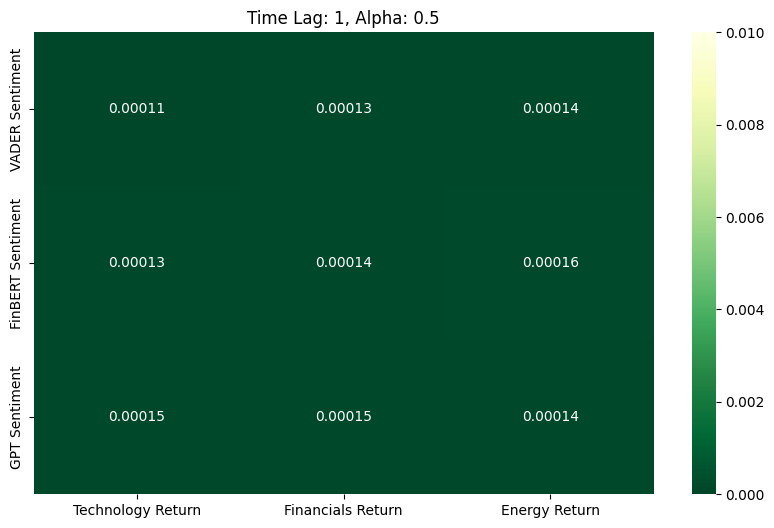

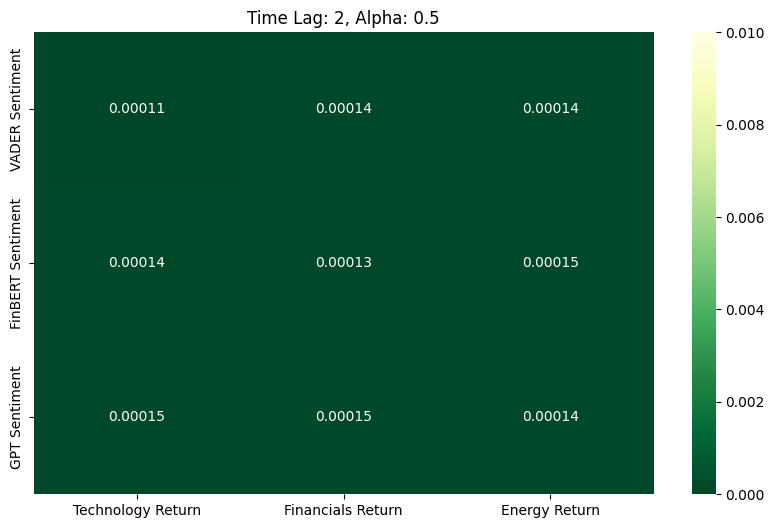

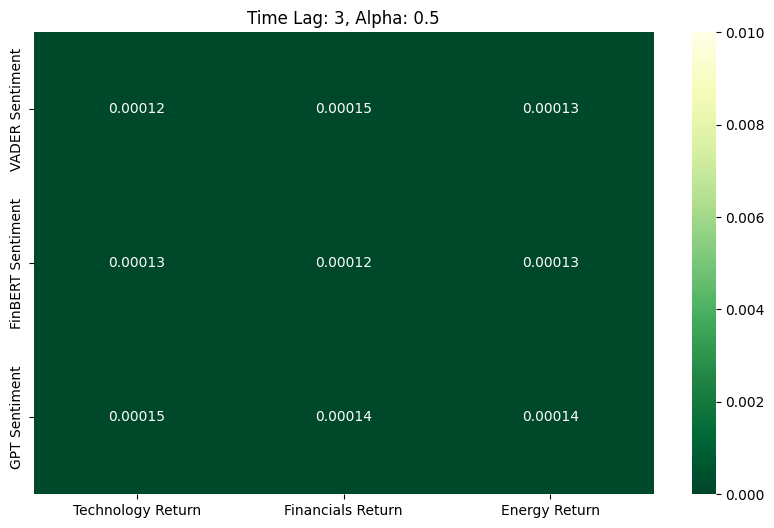

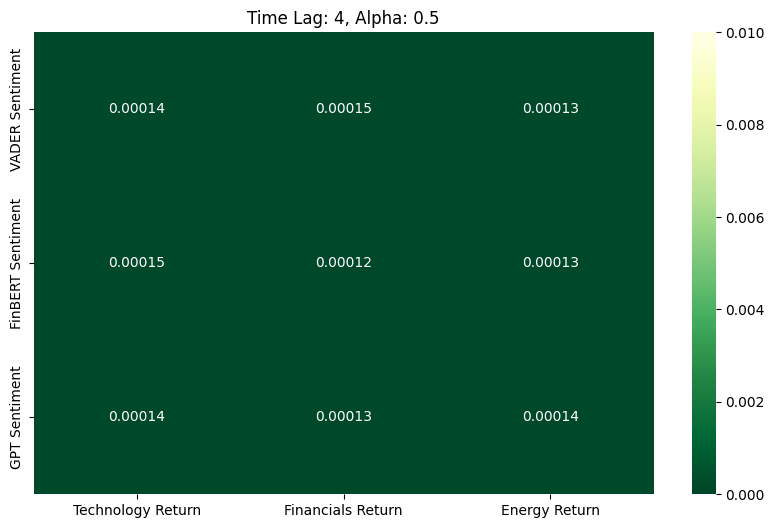

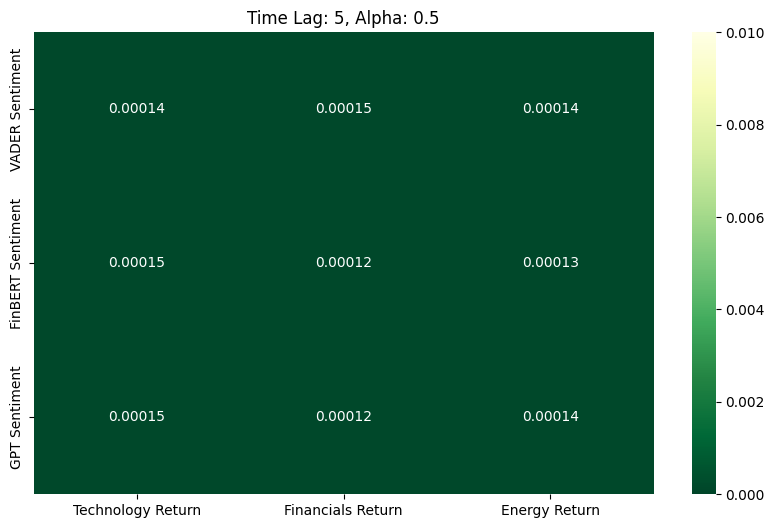

In [35]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize dictionaries to store the results for the new metrics
results = {}
mae_results = {}
r2_results = {}
rmse_results = {}

# Load data
sentiment_data_financials = pd.read_csv('Sentiment_Results_Financials_Sum.csv')
sentiment_data_energy = pd.read_csv('Sentiment_Results_Energy_Sum.csv')
sentiment_data_technology = pd.read_csv('Sentiment_Results_Technology_Sum.csv')
returns_data = pd.read_csv('Portfolio_Returns_Linear.csv')

# Merge datasets on Date, and only keep rows where both Sentiment and Return data are available
merged_data_financials = pd.merge(sentiment_data_financials, returns_data[['Date', 'Financials Return']], on='Date')
merged_data_energy = pd.merge(sentiment_data_energy, returns_data[['Date', 'Energy Return']], on='Date')
merged_data_technology = pd.merge(sentiment_data_technology, returns_data[['Date', 'Technology Return']], on='Date')

# Define the sentiments and returns
sentiments = ['VADER Sentiment', 'FinBERT Sentiment', 'GPT Sentiment']
returns = ['Technology Return', 'Financials Return', 'Energy Return']

# Schleife durch Sentiments und Returns
for sentiment in sentiments:
    for ret in returns:
        for timelag in range(1, 20):
            
            # Select the appropriate merged_data based on the return type
            if ret == 'Technology Return':
                merged_data = merged_data_technology
            elif ret == 'Financials Return':
                merged_data = merged_data_financials
            else:  # 'Energy Return'
                merged_data = merged_data_energy
            
            # Verschiebung der Renditen um den Time Lag
            lagged_returns = merged_data[ret].shift(timelag).dropna()
            
            # Apply 7-day moving average to the lagged returns
            smoothed_returns = lagged_returns.rolling(window=7).mean().dropna().values

            # Schneiden des Sentiments entsprechend des Time Lags und Konvertierung in eine Liste
            aligned_sentiments = merged_data[sentiment].iloc[timelag: -6].tolist()  # Adjust to match the smoothed_returns

            # Apply 7-day moving average to the sentiments
            smoothed_sentiments = pd.Series(aligned_sentiments).rolling(window=7).mean().dropna().tolist()

            X = np.array(smoothed_sentiments).reshape(-1, 1)
            y = np.array(smoothed_returns).reshape(-1, 1)  # Use the smoothed returns as the target variable


            tscv = TimeSeriesSplit(n_splits=5)

            scores = []
            for train_index, test_index in tscv.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                model = xgb.XGBRegressor(objective='reg:squarederror')
                model.fit(X_train, y_train)
                predictions = model.predict(X_test)
                mse_score = mean_squared_error(y_test, predictions)
                mae_score = mean_absolute_error(y_test, predictions)
                r2_score_value = r2_score(y_test, predictions)
                rmse_score = np.sqrt(mse_score)
                scores.append((mse_score, mae_score, r2_score_value, rmse_score))

            avg_mse, avg_mae, avg_r2, avg_rmse = np.mean(scores, axis=0)

            print(f"Sentiment: {sentiment}, Return: {ret}, Time Lag: {timelag}, Alpha: {alpha}, MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}, R2: {avg_r2:.4f}, RMSE: {avg_rmse:.4f}")

            # Update the results dictionaries
            key = (sentiment, ret, timelag, alpha)
            results[key] = avg_mse
            mae_results[key] = avg_mae
            r2_results[key] = avg_r2
            rmse_results[key] = avg_rmse


# Now let's plot the results as heatmaps
for timelag in range(1, 6):
    # Prepare the data for heatmap
    matrix_data = pd.DataFrame(index=sentiments, columns=returns)
    for sentiment in sentiments:
        for ret in returns:
            key = (sentiment, ret, timelag, alpha)
            matrix_data.loc[sentiment, ret] = results[key]

    plt.figure(figsize=(10, 6))
    
    # Use vmin and vmax to set the scale, and choose "YlGn" as the colormap
    sns.heatmap(matrix_data.astype(float), annot=True, cmap="YlGn_r", vmin=0, vmax=0.01)
    plt.title(f"Time Lag: {timelag}, Alpha: {alpha}")
    plt.show()




In [36]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import numpy as np
import pandas as pd

# Load data
sentiment_data_financials = pd.read_csv('Sentiment_Results_Financials_Sum.csv')
sentiment_data_energy = pd.read_csv('Sentiment_Results_Energy_Sum.csv')
sentiment_data_technology = pd.read_csv('Sentiment_Results_Technology_Sum.csv')
returns_data = pd.read_csv('Portfolio_Returns_Linear.csv')

# Merge datasets on Date, and only keep rows where both Sentiment and Return data are available
merged_data_financials = pd.merge(sentiment_data_financials, returns_data[['Date', 'Financials Return']], on='Date')
merged_data_energy = pd.merge(sentiment_data_energy, returns_data[['Date', 'Energy Return']], on='Date')
merged_data_technology = pd.merge(sentiment_data_technology, returns_data[['Date', 'Technology Return']], on='Date')

# Define the sentiments and returns
sentiments = ['VADER Sentiment', 'FinBERT Sentiment', 'GPT Sentiment']
returns = ['Technology Return', 'Financials Return', 'Energy Return']

# List of moving average windows to try
ma_windows = [3, 7, 14]

# List of time lags to try
time_lags = [1, 3, 5, 7]

# Function to calculate moving average
def moving_average(series, window_size):
    return series.rolling(window=window_size).mean().dropna()

# Iterate through moving average windows and time lags
for ma_window in ma_windows:
    for timelag in time_lags:
        for sentiment in sentiments:
            for ret in returns:

                # Determine the appropriate merged_data
                if ret == 'Technology Return':
                    merged_data = merged_data_technology
                elif ret == 'Financials Return':
                    merged_data = merged_data_financials
                else:  # 'Energy Return'
                    merged_data = merged_data_energy

                # Apply the moving average to both sentiment and returns
                ma_sentiment = moving_average(merged_data[sentiment], ma_window)
                ma_return = moving_average(merged_data[ret], ma_window)

                # Apply time lag to the moving average series
                lagged_ma_return = ma_return.shift(timelag).dropna().values
                aligned_ma_sentiment = ma_sentiment.iloc[timelag:].values

                # Prepare the input and target variables
                X = aligned_ma_sentiment.reshape(-1, 1)
                y = lagged_ma_return.reshape(-1, 1)

                # Time series cross-validation
                tscv = TimeSeriesSplit(n_splits=5)
                scores = []
                for train_index, test_index in tscv.split(X):
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]

                    model = xgb.XGBRegressor(objective='reg:squarederror')
                    model.fit(X_train, y_train)
                    predictions = model.predict(X_test)
                    mse_score = mean_squared_error(y_test, predictions)
                    mae_score = mean_absolute_error(y_test, predictions)
                    r2_score_value = r2_score(y_test, predictions)
                    scores.append((mse_score, mae_score, r2_score_value))

                avg_mse, avg_mae, avg_r2 = np.mean(scores, axis=0)

                print(f"MA Window: {ma_window}, Time Lag: {timelag}, Sentiment: {sentiment}, Return: {ret}, MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}, R2: {avg_r2:.4f}")


MA Window: 3, Time Lag: 1, Sentiment: VADER Sentiment, Return: Technology Return, MSE: 0.0003, MAE: 0.0135, R2: -0.5161
MA Window: 3, Time Lag: 1, Sentiment: VADER Sentiment, Return: Financials Return, MSE: 0.0002, MAE: 0.0107, R2: -0.2719
MA Window: 3, Time Lag: 1, Sentiment: VADER Sentiment, Return: Energy Return, MSE: 0.0003, MAE: 0.0128, R2: -0.2661
MA Window: 3, Time Lag: 1, Sentiment: FinBERT Sentiment, Return: Technology Return, MSE: 0.0003, MAE: 0.0136, R2: -0.7334
MA Window: 3, Time Lag: 1, Sentiment: FinBERT Sentiment, Return: Financials Return, MSE: 0.0002, MAE: 0.0105, R2: -0.2342
MA Window: 3, Time Lag: 1, Sentiment: FinBERT Sentiment, Return: Energy Return, MSE: 0.0003, MAE: 0.0133, R2: -0.3812
MA Window: 3, Time Lag: 1, Sentiment: GPT Sentiment, Return: Technology Return, MSE: 0.0003, MAE: 0.0128, R2: -0.4047
MA Window: 3, Time Lag: 1, Sentiment: GPT Sentiment, Return: Financials Return, MSE: 0.0002, MAE: 0.0109, R2: -0.3127
MA Window: 3, Time Lag: 1, Sentiment: GPT Sent

# Polynomial Regression Model

In [66]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product

# Load data
sentiment_data_financials = pd.read_csv('Sentiment_Results_Financials_Sum.csv')
sentiment_data_energy = pd.read_csv('Sentiment_Results_Energy_Sum.csv')
sentiment_data_technology = pd.read_csv('Sentiment_Results_Technology_Sum.csv')
returns_data = pd.read_csv('Portfolio_Returns_Linear.csv')

# Assuming the 'Date' columns are the same across all dataframes,
# drop redundant 'Date' columns and merge the dataframes
sentiment_data_financials = sentiment_data_financials.add_prefix('Financials_')
sentiment_data_energy = sentiment_data_energy.add_prefix('Energy_')
sentiment_data_technology = sentiment_data_technology.add_prefix('Technology_')

merged_data = pd.concat([sentiment_data_financials, sentiment_data_energy, sentiment_data_technology, returns_data], axis=1)
merged_data = merged_data.loc[:, ~merged_data.columns.duplicated()]

# Define the sentiments and returns
sentiments = ['Financials_VADER Sentiment', 'Energy_FinBERT Sentiment', 'Technology_GPT Sentiment']
returns = ['Technology Return', 'Financials Return', 'Energy Return']

# Define the range of hyperparameters to test
degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21 ,22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Initialize a list to store the results
results_list = []

# Iterate over all combinations of sentiments, returns, and hyperparameters
for sentiment, return_column, degree, alpha in product(sentiments, returns, degrees, alphas):
    # Apply exponential smoothing
    model = ExponentialSmoothing(merged_data[sentiment], trend='add')
    fit = model.fit(smoothing_level=alpha)
    smoothed_data = fit.fittedvalues

    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(smoothed_data.values.reshape(-1, 1))

    # Fit the linear model
    model = LinearRegression()
    model.fit(X_poly, merged_data[return_column])

    # Predict
    y_pred = model.predict(X_poly)

    # Evaluate
    mse = mean_squared_error(merged_data[return_column], y_pred)
    r2 = r2_score(merged_data[return_column], y_pred)

    # Store the results
    results_list.append({
        'sentiment': sentiment,
        'return': return_column,
        'degree': degree,
        'alpha': alpha,
        'mse': mse,
        'r2': r2
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results_list)

# Sort the results by R^2 score in descending order
results_df = results_df.sort_values('r2', ascending=False)

# Group the results by sentiment and return column, and take the first result from each group
best_results_per_combination = results_df.groupby(['sentiment', 'return']).first().reset_index()

# Print the best results for each sentiment-industry combination
print(best_results_per_combination)

                    sentiment             return  degree  alpha       mse  \
0    Energy_FinBERT Sentiment      Energy Return      15    0.1  0.000385   
1    Energy_FinBERT Sentiment  Financials Return      11    0.3  0.000283   
2    Energy_FinBERT Sentiment  Technology Return      11    0.3  0.000386   
3  Financials_VADER Sentiment      Energy Return      18    0.2  0.000381   
4  Financials_VADER Sentiment  Financials Return      20    0.1  0.000281   
5  Financials_VADER Sentiment  Technology Return      16    0.5  0.000378   
6    Technology_GPT Sentiment      Energy Return      13    0.1  0.000402   
7    Technology_GPT Sentiment  Financials Return      12    0.3  0.000293   
8    Technology_GPT Sentiment  Technology Return      14    0.7  0.000367   

         r2  
0  0.072804  
1  0.100812  
2  0.056075  
3  0.081969  
4  0.105627  
5  0.075265  
6  0.031350  
7  0.067296  
8  0.102247  


# Decision Tree Model

In [99]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product

# Load data
sentiment_data_financials = pd.read_csv('Sentiment_Results_Financials_Sum.csv')
sentiment_data_energy = pd.read_csv('Sentiment_Results_Energy_Sum.csv')
sentiment_data_technology = pd.read_csv('Sentiment_Results_Technology_Sum.csv')
returns_data = pd.read_csv('Portfolio_Returns_Linear.csv')

# Assuming the 'Date' columns are the same across all dataframes,
# drop redundant 'Date' columns and merge the dataframes
sentiment_data_financials = sentiment_data_financials.add_prefix('Financials_')
sentiment_data_energy = sentiment_data_energy.add_prefix('Energy_')
sentiment_data_technology = sentiment_data_technology.add_prefix('Technology_')

merged_data = pd.concat([sentiment_data_financials, sentiment_data_energy, sentiment_data_technology, returns_data], axis=1)
merged_data = merged_data.loc[:, ~merged_data.columns.duplicated()]

# Define the sentiments and returns
sentiments = ['Financials_VADER Sentiment', 'Energy_FinBERT Sentiment', 'Technology_GPT Sentiment']
returns = ['Technology Return', 'Financials Return', 'Energy Return']

# Define the range of hyperparameters to test
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
max_depths = [None, 5, 10, 15, 20] # You can set other values for max_depth as per your need

# Initialize a list to store the results
results_list = []

# Iterate over all combinations of sentiments, returns, and hyperparameters
for sentiment, return_column, alpha, max_depth in product(sentiments, returns, alphas, max_depths):
    # Apply exponential smoothing
    model = ExponentialSmoothing(merged_data[sentiment], trend='add')
    fit = model.fit(smoothing_level=alpha)
    smoothed_data = fit.fittedvalues.values.reshape(-1, 1)

    # Fit the Decision Tree model
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(smoothed_data, merged_data[return_column])

    # Predict
    y_pred = model.predict(smoothed_data)

    # Evaluate
    mse = mean_squared_error(merged_data[return_column], y_pred)
    r2 = r2_score(merged_data[return_column], y_pred)

    # Store the results
    results_list.append({
        'sentiment': sentiment,
        'return': return_column,
        'alpha': alpha,
        'max_depth': max_depth,
        'mse': mse,
        'r2': r2
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results_list)

# Sort the results by R^2 score in descending order
results_df = results_df.sort_values('r2', ascending=False)

# Group the results by sentiment and return column, and take the first result from each group
best_results_per_combination = results_df.groupby(['sentiment', 'return']).first().reset_index()

# Print the best results for each sentiment-industry combination
print(best_results_per_combination)


                    sentiment             return  alpha  max_depth  mse   r2
0    Energy_FinBERT Sentiment      Energy Return    0.1       20.0  0.0  1.0
1    Energy_FinBERT Sentiment  Financials Return    0.1       20.0  0.0  1.0
2    Energy_FinBERT Sentiment  Technology Return    0.7       20.0  0.0  1.0
3  Financials_VADER Sentiment      Energy Return    0.5       20.0  0.0  1.0
4  Financials_VADER Sentiment  Financials Return    0.6       20.0  0.0  1.0
5  Financials_VADER Sentiment  Technology Return    0.1       20.0  0.0  1.0
6    Technology_GPT Sentiment      Energy Return    0.4       20.0  0.0  1.0
7    Technology_GPT Sentiment  Financials Return    0.7       20.0  0.0  1.0
8    Technology_GPT Sentiment  Technology Return    0.4       20.0  0.0  1.0


# Random Forest Model

In [100]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler

# Load data
sentiment_data_financials = pd.read_csv('Sentiment_Results_Financials_Sum.csv')
sentiment_data_energy = pd.read_csv('Sentiment_Results_Energy_Sum.csv')
sentiment_data_technology = pd.read_csv('Sentiment_Results_Technology_Sum.csv')
returns_data = pd.read_csv('Portfolio_Returns_Linear.csv')

# Define the sentiments and returns
sentiments = ['VADER Sentiment', 'FinBERT Sentiment', 'GPT Sentiment']
returns = ['Technology Return', 'Financials Return', 'Energy Return']

# Merging data
data_financials = pd.merge(sentiment_data_financials, returns_data, on='Date')
data_energy = pd.merge(sentiment_data_energy, returns_data, on='Date')
data_technology = pd.merge(sentiment_data_technology, returns_data, on='Date')

datasets = [data_financials, data_energy, data_technology]

# Create DataFrames to store results
train_results = pd.DataFrame(columns=['sentiment', 'return', 'n_estimators', 'mse', 'r2', 'smoothing_level', 'smoothing_trend'])
test_results = pd.DataFrame(columns=['sentiment', 'return', 'mse', 'r2'])

# Modified exponential_smoothing function to return a DataFrame
def exponential_smoothing(series, alpha, trend):
    return pd.Series(ExponentialSmoothing(series, trend='add', seasonal=None).fit(smoothing_level=alpha, smoothing_trend=trend).fittedvalues)

N_ESTIMATORS = 100  # Number of trees in Random Forest

# Iterate through datasets, sentiments, and returns
for data in datasets:
    # Split the data into training and test sets
    train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)
    for sentiment in sentiments:
        for return_type in returns:
            X_train = train_data[[sentiment]]
            y_train = train_data[return_type]

            # MinMax scaling the sentiment to avoid negative values
            scaler = MinMaxScaler()
            X_train_scaled = scaler.fit_transform(X_train)

            def objective(params):
                n_estimators, smoothing_level, smoothing_trend = params
                smoothed = exponential_smoothing(X_train_scaled.flatten(), smoothing_level, smoothing_trend)
                X_combined = pd.DataFrame({'original': X_train_scaled.flatten(), 'smoothed': smoothed})
                rf_model = RandomForestRegressor(n_estimators=int(n_estimators))
                rf_model.fit(X_combined, y_train)
                y_pred = rf_model.predict(X_combined)
                r2 = r2_score(y_train, y_pred)
                return -r2  # Negate R2 to maximize it


            # Optimize the parameters
            result = minimize(objective, [N_ESTIMATORS, 0.5, 0.5], bounds=[(10, 200), (0.01, 0.99), (0.01, 0.99)], method='Powell')

            best_n_estimators, best_smoothing_level, best_smoothing_trend = result.x

            # Use best smoothing parameters
            smoothed_X_train = exponential_smoothing(X_train_scaled.flatten(), best_smoothing_level, best_smoothing_trend).values.flatten()
            X_combined_train = pd.DataFrame({'original': X_train_scaled.flatten(), 'smoothed': smoothed_X_train})

            # Train using best hyperparameters
            model_train_rf = RandomForestRegressor(n_estimators=int(best_n_estimators))
            model_train_rf.fit(X_combined_train, y_train)

            y_pred_train = model_train_rf.predict(X_combined_train)

            mse_train = mean_squared_error(y_train, y_pred_train)
            r2_train = r2_score(y_train, y_pred_train)

            new_train_row = pd.DataFrame({
                'sentiment': sentiment,
                'return': return_type,
                'n_estimators': int(best_n_estimators),
                'mse': mse_train,
                'r2': r2_train,
                'smoothing_level': best_smoothing_level,
                'smoothing_trend': best_smoothing_trend
            }, index=[0])
            train_results = pd.concat([train_results, new_train_row], ignore_index=True)

            # Test phase
            X_test = test_data[[sentiment]]
            y_test = test_data[return_type]
            X_test_scaled = scaler.transform(X_test) # Scale using the same scaler as training
            smoothed_X_test = exponential_smoothing(X_test_scaled.flatten(), best_smoothing_level, best_smoothing_trend)
            smoothed_X_test_combined = pd.DataFrame({'original': X_test_scaled.flatten(), 'smoothed': smoothed_X_test})

            y_pred_test = model_train_rf.predict(smoothed_X_test_combined)

            mse_test = mean_squared_error(y_test, y_pred_test)
            r2_test = r2_score(y_test, y_pred_test)

            new_test_row = pd.DataFrame({
                'sentiment': sentiment,
                'return': return_type,
                'mse': mse_test,
                'r2': r2_test
            }, index=[0])
            test_results = pd.concat([test_results, new_test_row], ignore_index=True)

print("Training results:")
print(train_results)

print("Test results:")
print(test_results)


Training results:
            sentiment             return n_estimators       mse        r2  \
0     VADER Sentiment  Technology Return           79  0.000074  0.814981   
1     VADER Sentiment  Financials Return           82  0.000057  0.833676   
2     VADER Sentiment      Energy Return          151  0.000076  0.833420   
3   FinBERT Sentiment  Technology Return           76  0.000068  0.829050   
4   FinBERT Sentiment  Financials Return           44  0.000067  0.806404   
5   FinBERT Sentiment      Energy Return           82  0.000075  0.835568   
6       GPT Sentiment  Technology Return          105  0.000073  0.817351   
7       GPT Sentiment  Financials Return          155  0.000053  0.844759   
8       GPT Sentiment      Energy Return          134  0.000074  0.837009   
9     VADER Sentiment  Technology Return           94  0.000066  0.835131   
10    VADER Sentiment  Financials Return           82  0.000060  0.827012   
11    VADER Sentiment      Energy Return          172  0.0

In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

# Load data
sentiment_data_financials = pd.read_csv('Sentiment_Results_Financials_Sum.csv')
sentiment_data_energy = pd.read_csv('Sentiment_Results_Energy_Sum.csv')
sentiment_data_technology = pd.read_csv('Sentiment_Results_Technology_Sum.csv')
returns_data = pd.read_csv('Portfolio_Returns_Linear.csv')

# Define the sentiments and returns
sentiments = ['VADER Sentiment', 'FinBERT Sentiment', 'GPT Sentiment']
returns = ['Technology Return', 'Financials Return', 'Energy Return']

# Merging data
data_financials = pd.merge(sentiment_data_financials, returns_data, on='Date')
data_energy = pd.merge(sentiment_data_energy, returns_data, on='Date')
data_technology = pd.merge(sentiment_data_technology, returns_data, on='Date')

datasets = [data_financials, data_energy, data_technology]

# Create DataFrames to store results
train_results = pd.DataFrame(columns=['sentiment', 'return', 'n_estimators', 'mse', 'r2'])
test_results = pd.DataFrame(columns=['sentiment', 'return', 'mse', 'r2'])

# Modified exponential_smoothing function to return a DataFrame
def exponential_smoothing(series, alpha, trend):
    return pd.Series(ExponentialSmoothing(series, trend='add', seasonal=None).fit(smoothing_level=alpha, smoothing_trend=trend).fittedvalues)

N_ESTIMATORS = 100  # Number of trees in Random Forest

# Iterate through datasets, sentiments, and returns
for data in datasets:
    # Split the data into training and test sets
    train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False) # Increase test size
    for sentiment in sentiments:
        for return_type in returns:
            X_train = train_data[[sentiment]]
            y_train = train_data[return_type]

            # MinMax scaling the sentiment to avoid negative values
            scaler = MinMaxScaler()
            X_train_scaled = scaler.fit_transform(X_train)

            # Train using Random Forest with Grid Search for hyperparameter tuning
            param_grid = {'n_estimators': range(10, 200, 10),
                          'max_depth': [None, 10, 20, 30],
                          'min_samples_split': [2, 5, 10],
                          'min_samples_leaf': [1, 2, 4]}

            rf_model = RandomForestRegressor()
            grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                                       cv=3, n_jobs=-1, scoring='r2') # 3-fold cross-validation
            grid_search.fit(X_train_scaled, y_train)
            best_rf_model = grid_search.best_estimator_

            y_pred_train = best_rf_model.predict(X_train_scaled)

            mse_train = mean_squared_error(y_train, y_pred_train)
            r2_train = r2_score(y_train, y_pred_train)

            new_train_row = pd.DataFrame({
                'sentiment': sentiment,
                'return': return_type,
                'n_estimators': grid_search.best_params_['n_estimators'],
                'mse': mse_train,
                'r2': r2_train
            }, index=[0])
            train_results = pd.concat([train_results, new_train_row], ignore_index=True)

            # Test phase
            X_test = test_data[[sentiment]]
            y_test = test_data[return_type]
            X_test_scaled = scaler.transform(X_test) # Scale using the same scaler as training

            y_pred_test = best_rf_model.predict(X_test_scaled)

            mse_test = mean_squared_error(y_test, y_pred_test)
            r2_test = r2_score(y_test, y_pred_test)

            new_test_row = pd.DataFrame({
                'sentiment': sentiment,
                'return': return_type,
                'mse': mse_test,
                'r2': r2_test
            }, index=[0])
            test_results = pd.concat([test_results, new_test_row], ignore_index=True)

print("Training results:")
print(train_results)

print("Test results:")
print(test_results)

Training results:
            sentiment             return n_estimators       mse        r2
0     VADER Sentiment  Technology Return           10  0.000375  0.067398
1     VADER Sentiment  Financials Return           20  0.000313  0.042856
2     VADER Sentiment      Energy Return           10  0.000407  0.043566
3   FinBERT Sentiment  Technology Return           20  0.000380  0.055194
4   FinBERT Sentiment  Financials Return           10  0.000317  0.032955
5   FinBERT Sentiment      Energy Return           10  0.000398  0.065712
6       GPT Sentiment  Technology Return           30  0.000380  0.054910
7       GPT Sentiment  Financials Return           10  0.000308  0.058513
8       GPT Sentiment      Energy Return           10  0.000420  0.013553
9     VADER Sentiment  Technology Return           10  0.000390  0.031292
10    VADER Sentiment  Financials Return           30  0.000308  0.058788
11    VADER Sentiment      Energy Return           20  0.000406  0.046778
12  FinBERT Sentimen

In [115]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

# Load data
sentiment_data_financials = pd.read_csv('Sentiment_Results_Financials_Sum.csv')
sentiment_data_energy = pd.read_csv('Sentiment_Results_Energy_Sum.csv')
sentiment_data_technology = pd.read_csv('Sentiment_Results_Technology_Sum.csv')
returns_data = pd.read_csv('Portfolio_Returns_Linear.csv')

# Define the sentiments and returns
sentiments = ['VADER Sentiment', 'FinBERT Sentiment', 'GPT Sentiment']
returns = ['Technology Return', 'Financials Return', 'Energy Return']

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create Time Series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Instantiate grid search with time-series cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                          cv=tscv, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X, y) # Notice you're fitting on the whole dataset without the train-test split


# Adding lagged returns
def add_lagged_returns(data, returns_column, lags=5):
    for lag in range(1, lags + 1):
        data[f'{returns_column}_lag_{lag}'] = data[returns_column].shift(lag)
    return data.dropna()

# Adding other transformations (e.g., rolling averages)
def add_features(data, returns_column):
    data[f'{returns_column}_rolling_mean_5'] = data[returns_column].rolling(window=5).mean()
    data[f'{returns_column}_rolling_mean_10'] = data[returns_column].rolling(window=10).mean()
    return data.dropna()

# Store the results
results = []

# Loop over sentiments and returns to train a model for each
for sentiment in sentiments:
    for return_col in returns:
        # Prepare data for each sector
        if 'Technology' in return_col:
            sector_data = sentiment_data_technology
        elif 'Financials' in return_col:
            sector_data = sentiment_data_financials
        elif 'Energy' in return_col:
            sector_data = sentiment_data_energy
        
        # Join sentiment and return data
        data = pd.merge(sector_data[[sentiment, 'Date']], returns_data[[return_col, 'Date']], on='Date')
        print(data.shape) # Check shape here

        # Add lagged returns and other features
        data = add_lagged_returns(data, return_col)
        data = add_features(data, return_col)
        print(data.shape) # Check shape here

        # Drop rows with missing values
        data.dropna(inplace=True)
        print(data.shape) # Check shape here

        # Split into X and y
        X = data.drop(columns=[return_col, 'Date'])
        y = data[return_col]

        
        # Split the data into training and testing sets based on a specific date
        split_date = '2022-09-01'
        train_data = data[data['Date'] < split_date]
        test_data = data[data['Date'] >= split_date]
        X_train, y_train = train_data.drop(columns=[return_col, 'Date']), train_data[return_col]
        X_test, y_test = test_data.drop(columns=[return_col, 'Date']), test_data[return_col]
        print(X_train.shape, y_train.shape) # Check shapes here
        print(data['Date'].min(), data['Date'].max())
        print(data[data['Date'] < split_date].tail())
        print(data[data['Date'] >= split_date].head())

        # Create Random Forest model
        rf = RandomForestRegressor(random_state=42)

        # Instantiate grid search with cross-validation
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                                  cv=3, n_jobs=-1, verbose=2)

        # Fit the grid search to the data
        grid_search.fit(X_train, y_train)

        # Find the best hyperparameters
        best_params = grid_search.best_params_
        print(f"Best Parameters: {best_params}")

        # Use the Random Forest model with the best hyperparameters
        best_rf = grid_search.best_estimator_

        # Make predictions
        y_pred = best_rf.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Save the results
        result = {
            'sentiment': sentiment,
            'return': return_col,
            'best_params': best_params,
            'mse': mse,
            'r2': r2
        }
        results.append(result)

# Print all results
for result in results:
    print(f"Sentiment: {result['sentiment']}, Return: {result['return']}")
    print(f"Best Parameters: {result['best_params']}")
    print(f"MSE: {result['mse']}, R²: {result['r2']}\n")

# Sort the results by R² and print the best ones
results.sort(key=lambda x: x['r2'], reverse=True)
print("Top Results:")
for result in results[:3]:
    print(f"Sentiment: {result['sentiment']}, Return: {result['return']}")
    print(f"Best Parameters: {result['best_params']}")
    print(f"MSE: {result['mse']}, R²: {result['r2']}\n")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_de

In [117]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd

# Load data
sentiment_data_financials = pd.read_csv('Sentiment_Results_Financials_Sum.csv')
sentiment_data_energy = pd.read_csv('Sentiment_Results_Energy_Sum.csv')
sentiment_data_technology = pd.read_csv('Sentiment_Results_Technology_Sum.csv')
returns_data = pd.read_csv('Portfolio_Returns_Linear.csv')

# Define the sentiments and returns
sentiments = ['VADER Sentiment', 'FinBERT Sentiment', 'GPT Sentiment']
returns = ['Technology Return', 'Financials Return', 'Energy Return']

# Define the hyperparameter grid for each model
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Support Vector Machine': {
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.5],
        'kernel': ['linear', 'rbf']
    }
}


# Adding lagged returns
def add_lagged_returns(data, returns_column, lags=5):
    for lag in range(1, lags + 1):
        data[f'{returns_column}_lag_{lag}'] = data[returns_column].shift(lag)
    return data.dropna()

# Adding other transformations (e.g., rolling averages)
def add_features(data, returns_column):
    data[f'{returns_column}_rolling_mean_5'] = data[returns_column].rolling(window=5).mean()
    data[f'{returns_column}_rolling_mean_10'] = data[returns_column].rolling(window=10).mean()
    data[f'{returns_column}_ewm_5'] = data[returns_column].ewm(span=5).mean()
    return data.dropna()

# Adding difference between current and previous observation
def add_difference(data, returns_column):
    data[f'{returns_column}_diff'] = data[returns_column].diff()
    return data.dropna()

# Store the results
results = []

# Loop over sentiments and returns to train a model for each
for sentiment in sentiments:
    for return_col in returns:
        # Prepare data for each sector
        if 'Technology' in return_col:
            sector_data = sentiment_data_technology
        elif 'Financials' in return_col:
            sector_data = sentiment_data_financials
        elif 'Energy' in return_col:
            sector_data = sentiment_data_energy
        
        # Join sentiment and return data
        data = pd.merge(sector_data[[sentiment, 'Date']], returns_data[[return_col, 'Date']], on='Date')
        
        # Add lagged returns and other features
        data = add_lagged_returns(data, return_col)
        data = add_features(data, return_col)
        data = add_difference(data, return_col)

        # Split into X and y
        X = data.drop(columns=[return_col, 'Date'])
        y = data[return_col]

        # Split the data into training and testing sets based on a specific date
        split_date = '2022-09-01'
        train_data = data[data['Date'] < split_date]
        test_data = data[data['Date'] >= split_date]
        X_train, y_train = train_data.drop(columns=[return_col, 'Date']), train_data[return_col]
        X_test, y_test = test_data.drop(columns=[return_col, 'Date']), test_data[return_col]

        # Hyperparameter grid for RandomForest and GradientBoosting
        param_grid_rf_gb = {
            'model__n_estimators': [50, 100, 150],
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        }

        # Hyperparameter grid for SVR
        param_grid_svr = {
            'model__C': [0.1, 1, 10],
            'model__epsilon': [0.01, 0.1, 0.5],
            'model__kernel': ['linear', 'rbf']
        }

        # Exploring different models
        models = [
            ('Random Forest', RandomForestRegressor(random_state=42), param_grid_rf_gb),
            ('Gradient Boosting', GradientBoostingRegressor(random_state=42), param_grid_rf_gb),
            ('Support Vector Machine', SVR(), param_grid_svr)
        ]

        for name, model, param_grid in models:
            # Note the change here: using param_grids[name]
            grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=3, n_jobs=-1, verbose=2)
            
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', grid_search)
            ])

            # Fit the pipeline to the data
            pipeline.fit(X_train, y_train)

            # Find the best hyperparameters
            best_params = pipeline.named_steps['model'].best_params_
            print(f"{name} Best Parameters: {best_params}")

            # Make predictions
            y_pred = pipeline.predict(X_test)

            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # Save the results
            result = {
                'model': name,
                'sentiment': sentiment,
                'return': return_col,
                'best_params': best_params,
                'mse': mse,
                'r2': r2
            }
            results.append(result)

# Print all results
for result in results:
    print(f"Model: {result['model']}, Sentiment: {result['sentiment']}, Return: {result['return']}")
    print(f"Best Parameters: {result['best_params']}")
    print(f"MSE: {result['mse']}, R²: {result['r2']}\n")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_dep

# Multiple Model Analysis

Description of the Model:

Data Source: The code reads a CSV file named 'results.csv', which contains columns representing different combinations of sentiments and predictive models ('RF', 'GB', 'VM') along with a specific column named 'Return(Lag)/Sentiment&Model'. The exact structure of the CSV is not fully detailed in the code, but it seems to contain information related to the return of different industries, with various lags and sentiments.

Sentiments Analyzed: The code considers three different sentiments, namely 'VADER Sentiment', 'FinBERT Sentiment', and 'GPT Sentiment'.

Models Analyzed: Three different models are considered in the analysis: Random Forest ('RF'), Gradient Boosting ('GB'), and a third model ('VM'), whose details are not provided.

Time-Lags Considered: The code appears to analyze time lags, specifically looking for lags labeled as 'Lag 1' to 'Lag 5'. The lag details are extracted from the 'Return(Lag)/Sentiment&Model' column. The selected lags are then counted and displayed.

Result Aggregation: For each industry, the code iterates through the sentiments and models, checking the value of each combination. If a value is higher than the existing one (or if it's the first value), it updates a result matrix with the corresponding lag and value. This means the code is identifying the best lag for each combination of industry, sentiment, and model.

Output: The final result is converted into a DataFrame and printed, along with a count of how many times each lag was selected as the best lag.

Averages or Smoothing: The code doesn't seem to involve any specific averaging or smoothing techniques for the analyzed data.



In [1]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
import numpy as np
import json

# Load data
sentiment_data_financials = pd.read_csv('Sentiment_Results_Financials_Sum.csv')
sentiment_data_energy = pd.read_csv('Sentiment_Results_Energy_Sum.csv')
sentiment_data_technology = pd.read_csv('Sentiment_Results_Technology_Sum.csv')
returns_data = pd.read_csv('Portfolio_Returns_Linear.csv')

# Define the sentiments and returns
sentiments = ['VADER Sentiment', 'FinBERT Sentiment', 'GPT Sentiment']
returns = ['Technology Return', 'Financials Return', 'Energy Return']
models = ['RF', 'GB', 'VM']

# Store the results in a DataFrame
results_df = pd.DataFrame(columns=['Return(Lag)/Sentiment&Model'] + [f'{s} {m}' for s in sentiments for m in models])


# Define the hyperparameter grid for each model
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Support Vector Machine': {
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.5],
        'kernel': ['linear', 'rbf']
    }
}


# Adding lagged returns
def add_lagged_returns(data, returns_column, lags=5):
    for lag in range(1, lags + 1):
        data[f'{returns_column}_lag_{lag}'] = data[returns_column].shift(lag)
    return data.dropna()

# Adding other transformations (e.g., rolling averages)
def add_features(data, returns_column):
    data[f'{returns_column}_rolling_mean_5'] = data[returns_column].rolling(window=5).mean()
    data[f'{returns_column}_rolling_mean_10'] = data[returns_column].rolling(window=10).mean()
    data[f'{returns_column}_ewm_5'] = data[returns_column].ewm(span=5).mean()
    return data.dropna()

# Adding difference between current and previous observation
def add_difference(data, returns_column):
    data[f'{returns_column}_diff'] = data[returns_column].diff()
    return data.dropna()

# Store the results
results = []

# Define lags to test
lags_to_test = [1, 2, 3, 4, 5]

# Define models
models = [
    ('RF', RandomForestRegressor(random_state=42), param_grids['Random Forest']),
    ('GB', GradientBoostingRegressor(random_state=42), param_grids['Gradient Boosting']),
    ('VM', SVR(), param_grids['Support Vector Machine'])
]

# Define a dictionary to store the best parameters
best_parameters = {
    sentiment: {
        return_col: {
            str(lag): {
                model_name: {} for model_name, _, _ in models
            } for lag in lags_to_test
        } for return_col in returns
    } for sentiment in sentiments
}




# Loop over sentiments, returns, lags, and models to train for each combination
for sentiment in sentiments:
    for return_col in returns:
        # Prepare data for each sector
        if 'Technology' in return_col:
            sector_data = sentiment_data_technology
        elif 'Financials' in return_col:
            sector_data = sentiment_data_financials
        elif 'Energy' in return_col:
            sector_data = sentiment_data_energy

        # Join sentiment and return data
        data = pd.merge(sector_data[[sentiment, 'Date']], returns_data[[return_col, 'Date']], on='Date')

        for lag in lags_to_test:
            # Make a copy of the original data
            lagged_data = data.copy()

            # Add lagged returns with the current lag value
            lagged_data = add_lagged_returns(lagged_data, return_col, lags=lag)

            # Add other features
            lagged_data = add_features(lagged_data, return_col)
            lagged_data = add_difference(lagged_data, return_col)

            # Split into X and y
            X = lagged_data.drop(columns=[return_col, 'Date'])
            y = lagged_data[return_col]

            # Split the data into training and testing sets based on a specific date
            split_date = '2022-09-01'
            train_data = lagged_data[lagged_data['Date'] < split_date]
            test_data = lagged_data[lagged_data['Date'] >= split_date]
            X_train, y_train = train_data.drop(columns=[return_col, 'Date']), train_data[return_col]
            X_test, y_test = test_data.drop(columns=[return_col, 'Date']), test_data[return_col]

            for model_name, model, param_grid in models:
                # Define the pipeline
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('model', model)
                ])

                # Store the best score and corresponding parameters
                best_score = float('-inf')
                best_params = None


                # Loop through the parameter grid manually using ParameterGrid
                for params in ParameterGrid(param_grid):
                    if model_name in ['RF', 'GB']:
                        pipeline.set_params(model__n_estimators=params['n_estimators'], model__max_depth=params['max_depth'],
                                            model__min_samples_split=params['min_samples_split'], model__min_samples_leaf=params['min_samples_leaf'])
                    elif model_name == 'VM':
                        pipeline.set_params(model__C=params['C'], model__epsilon=params['epsilon'], model__kernel=params['kernel'])


                    # Perform time series cross-validation
                    tscv = TimeSeriesSplit(n_splits=5)
                    scores = []
                    for train_idx, val_idx in tscv.split(X_train):
                        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
                        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

                        # Fit the pipeline
                        pipeline.fit(X_train_fold, y_train_fold)

                        # Validate the model
                        y_pred_fold = pipeline.predict(X_val_fold)
                        score = r2_score(y_val_fold, y_pred_fold)
                        scores.append(score)

                    # Compute the mean of the scores
                    mean_score = np.mean(scores)

                    if mean_score > best_score:
                        best_score = mean_score
                        best_params = params

                # Set the best parameters
                if model_name in ['RF', 'GB']:
                    pipeline.set_params(model__n_estimators=best_params['n_estimators'],
                                        model__max_depth=best_params['max_depth'],
                                        model__min_samples_split=best_params['min_samples_split'],
                                        model__min_samples_leaf=best_params['min_samples_leaf'])
                elif model_name == 'VM':
                    pipeline.set_params(model__C=best_params['C'],
                                        model__epsilon=best_params['epsilon'],
                                        model__kernel=best_params['kernel'])

                best_parameters[sentiment][return_col][str(lag)][model_name] = best_params

                # Train on the entire training set
                pipeline.fit(X_train, y_train)

                # Test on the test set
                y_pred = pipeline.predict(X_test)

                # Calculate metrics
                mse = mean_squared_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)

                # Save the results, including the lag and model name
                result_key = f'{return_col.split(" ")[0]} Lag {lag}/{sentiment}'
                result_value = f'{sentiment} {model_name}'
                results_df.loc[result_key, 'Return(Lag)/Sentiment&Model'] = result_key
                results_df.loc[result_key, result_value] = r2

with open('best_parameters.json', 'w') as file:
    json.dump(best_parameters, file)

# Save results to CSV
results_df.to_csv('results.csv', index=False)

In [3]:
import pandas as pd

# Read the CSV file
file_path = 'results.csv'
data = pd.read_csv(file_path)

# Define the models
models = ['RF', 'GB', 'VM']
sentiments = ['VADER Sentiment', 'FinBERT Sentiment', 'GPT Sentiment']

# Create a dictionary to store the results
result_matrix = {}

# Create a counter for lags
lag_counter = {f'Lag {i}': 0 for i in range(1, 6)}

# Iterate through the industries, sentiments, and models
for index, row in data.iterrows():
    industry_lag_value = row['Return(Lag)/Sentiment&Model']
    
    # Skip this row if the value is NaN
    if pd.isna(industry_lag_value):
        continue
    
    industry_lag = str(industry_lag_value).split(' ')
    industry = " ".join(industry_lag[:-2])
    lag = " ".join(industry_lag[-2:])

    for sentiment in sentiments:
        for model in models:
            col_name = f'{sentiment} {model}'
            value = row[col_name]
            key = f'{industry} - {sentiment} {model}'
            # If the value is higher than the existing value (or if this is the first value), update the result
            if key not in result_matrix or value > result_matrix[key][1]:
                result_matrix[key] = (lag, value)
                # Increment the lag counter
                lag_counter[lag] += 1

# Convert the result to a DataFrame and print
result_df = pd.DataFrame.from_dict(result_matrix, orient='index', columns=['Best Lag', 'Value'])
print(result_df)

# Print the lag counter
lag_counter_df = pd.DataFrame.from_dict(lag_counter, orient='index', columns=['Count'])
print("\nLag Counts:")
print(lag_counter_df)


                                  Best Lag     Value
Technology - VADER Sentiment RF      Lag 1  0.869341
Technology - VADER Sentiment GB      Lag 1  0.896297
Technology - VADER Sentiment VM      Lag 1  0.946674
Technology - FinBERT Sentiment RF    Lag 3  0.857605
Technology - FinBERT Sentiment GB    Lag 5  0.877304
Technology - FinBERT Sentiment VM    Lag 1  0.953540
Technology - GPT Sentiment RF        Lag 1  0.865185
Technology - GPT Sentiment GB        Lag 2  0.886669
Technology - GPT Sentiment VM        Lag 1  0.960725
Financials - VADER Sentiment RF      Lag 3  0.891856
Financials - VADER Sentiment GB      Lag 2  0.920508
Financials - VADER Sentiment VM      Lag 1  0.954462
Financials - FinBERT Sentiment RF    Lag 1  0.896324
Financials - FinBERT Sentiment GB    Lag 3  0.915054
Financials - FinBERT Sentiment VM    Lag 2  0.955678
Financials - GPT Sentiment RF        Lag 1  0.895143
Financials - GPT Sentiment GB        Lag 5  0.927540
Financials - GPT Sentiment VM        Lag 2  0.

### Just lag 2

In [12]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
import numpy as np
import json

# Load data
sentiment_data_financials = pd.read_csv('Sentiment_Results_Financials_Sum.csv')
sentiment_data_energy = pd.read_csv('Sentiment_Results_Energy_Sum.csv')
sentiment_data_technology = pd.read_csv('Sentiment_Results_Technology_Sum.csv')
returns_data = pd.read_csv('Portfolio_Returns_Linear.csv')

# Define the sentiments and returns
sentiments = ['VADER Sentiment', 'FinBERT Sentiment', 'GPT Sentiment']
returns = ['Technology Return', 'Financials Return', 'Energy Return']
models = ['RF', 'GB', 'VM']

# Store the results in a DataFrame
results_df = pd.DataFrame(columns=['Return(Lag)/Sentiment&Model'] + [f'{s} {m} R2' for s in sentiments for m in models] + [f'{s} {m} MSE' for s in sentiments for m in models])


# Define the hyperparameter grid for each model
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Support Vector Machine': {
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.5],
        'kernel': ['linear', 'rbf']
    }
}


# Adding lagged returns
def add_lagged_returns(data, returns_column, lags=5):
    for lag in range(1, lags + 1):
        data[f'{returns_column}_lag_{lag}'] = data[returns_column].shift(lag)
    return data.dropna()

# Adding other transformations (e.g., rolling averages)
def add_features(data, returns_column):
    data[f'{returns_column}_rolling_mean_5'] = data[returns_column].rolling(window=5).mean()
    data[f'{returns_column}_rolling_mean_10'] = data[returns_column].rolling(window=10).mean()
    data[f'{returns_column}_ewm_5'] = data[returns_column].ewm(span=5).mean()
    return data.dropna()

# Adding difference between current and previous observation
def add_difference(data, returns_column):
    data[f'{returns_column}_diff'] = data[returns_column].diff()
    return data.dropna()

# Store the results
results = []

# Define lags to test - testing only lag 2
lags_to_test = [1]

# Define models
models = [
    ('RF', RandomForestRegressor(random_state=42), param_grids['Random Forest']),
    ('GB', GradientBoostingRegressor(random_state=42), param_grids['Gradient Boosting']),
    ('VM', SVR(), param_grids['Support Vector Machine'])
]

# Define a dictionary to store the best parameters
best_parameters = {
    sentiment: {
        return_col: {
            str(lag): {
                model_name: {} for model_name, _, _ in models
            } for lag in lags_to_test
        } for return_col in returns
    } for sentiment in sentiments
}




# Loop over sentiments, returns, lags, and models to train for each combination
for sentiment in sentiments:
    for return_col in returns:
        # Prepare data for each sector
        if 'Technology' in return_col:
            sector_data = sentiment_data_technology
        elif 'Financials' in return_col:
            sector_data = sentiment_data_financials
        elif 'Energy' in return_col:
            sector_data = sentiment_data_energy

        # Join sentiment and return data
        data = pd.merge(sector_data[[sentiment, 'Date']], returns_data[[return_col, 'Date']], on='Date')

        for lag in lags_to_test:
            # Make a copy of the original data
            lagged_data = data.copy()

            # Add lagged returns with the current lag value
            lagged_data = add_lagged_returns(lagged_data, return_col, lags=lag)

            # Add other features
            lagged_data = add_features(lagged_data, return_col)
            lagged_data = add_difference(lagged_data, return_col)

            # Split into X and y
            X = lagged_data.drop(columns=[return_col, 'Date'])
            y = lagged_data[return_col]

            # Split the data into training and testing sets based on a specific date
            split_date = '2022-09-01'
            train_data = lagged_data[lagged_data['Date'] < split_date]
            test_data = lagged_data[lagged_data['Date'] >= split_date]
            X_train, y_train = train_data.drop(columns=[return_col, 'Date']), train_data[return_col]
            X_test, y_test = test_data.drop(columns=[return_col, 'Date']), test_data[return_col]

            for model_name, model, param_grid in models:
                # Define the pipeline
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('model', model)
                ])

                # Store the best score and corresponding parameters
                best_score = float('-inf')
                best_params = None


                # Loop through the parameter grid manually using ParameterGrid
                for params in ParameterGrid(param_grid):
                    if model_name in ['RF', 'GB']:
                        pipeline.set_params(model__n_estimators=params['n_estimators'], model__max_depth=params['max_depth'],
                                            model__min_samples_split=params['min_samples_split'], model__min_samples_leaf=params['min_samples_leaf'])
                    elif model_name == 'VM':
                        pipeline.set_params(model__C=params['C'], model__epsilon=params['epsilon'], model__kernel=params['kernel'])


                    # Perform time series cross-validation
                    tscv = TimeSeriesSplit(n_splits=5)
                    scores = []
                    for train_idx, val_idx in tscv.split(X_train):
                        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
                        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

                        # Fit the pipeline
                        pipeline.fit(X_train_fold, y_train_fold)

                        # Validate the model
                        y_pred_fold = pipeline.predict(X_val_fold)
                        score = r2_score(y_val_fold, y_pred_fold)
                        scores.append(score)

                    # Compute the mean of the scores
                    mean_score = np.mean(scores)

                    if mean_score > best_score:
                        best_score = mean_score
                        best_params = params

                # Set the best parameters
                if model_name in ['RF', 'GB']:
                    pipeline.set_params(model__n_estimators=best_params['n_estimators'],
                                        model__max_depth=best_params['max_depth'],
                                        model__min_samples_split=best_params['min_samples_split'],
                                        model__min_samples_leaf=best_params['min_samples_leaf'])
                elif model_name == 'VM':
                    pipeline.set_params(model__C=best_params['C'],
                                        model__epsilon=best_params['epsilon'],
                                        model__kernel=best_params['kernel'])

                best_parameters[sentiment][return_col][str(lag)][model_name] = best_params

                # Train on the entire training set
                pipeline.fit(X_train, y_train)

                # Test on the test set
                y_pred = pipeline.predict(X_test)

                # Calculate metrics
                mse = mean_squared_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)

                # Save the results, including the lag and model name
                result_key = f'{return_col.split(" ")[0]} Lag {lag}/{sentiment}'
                result_value_r2 = f'{sentiment} {model_name} R2'
                result_value_mse = f'{sentiment} {model_name} MSE'
                results_df.loc[result_key, 'Return(Lag)/Sentiment&Model'] = result_key
                results_df.loc[result_key, result_value_r2] = r2
                results_df.loc[result_key, result_value_mse] = mse


with open('best_parameters_lag1.json', 'w') as file:
    json.dump(best_parameters, file)

# Save results to CSV
results_df.to_csv('results_lag1.csv', index=False)

            Industry          Sentiment Model        R2       MSE
0   Technology Lag 2    VADER Sentiment    RF  0.857305  0.000058
1   Technology Lag 2    VADER Sentiment    GB  0.894555  0.000043
2   Technology Lag 2    VADER Sentiment    VM  0.930391  0.000028
3   Technology Lag 2  FinBERT Sentiment    RF  0.853584  0.000059
4   Technology Lag 2  FinBERT Sentiment    GB  0.876698  0.000050
5   Technology Lag 2  FinBERT Sentiment    VM  0.940923  0.000024
6   Technology Lag 2      GPT Sentiment    RF  0.860516  0.000056
7   Technology Lag 2      GPT Sentiment    GB  0.886669  0.000046
8   Technology Lag 2      GPT Sentiment    VM  0.942592  0.000023
9   Financials Lag 2    VADER Sentiment    RF  0.890393  0.000029
10  Financials Lag 2    VADER Sentiment    GB  0.920508  0.000021
11  Financials Lag 2    VADER Sentiment    VM  0.953818  0.000012
12  Financials Lag 2  FinBERT Sentiment    RF  0.890733  0.000029
13  Financials Lag 2  FinBERT Sentiment    GB  0.914850  0.000023
14  Financ

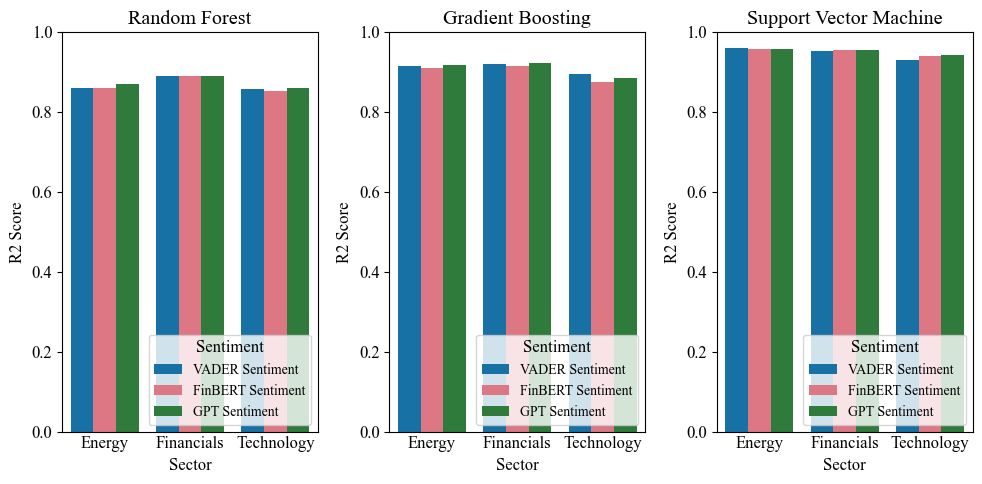

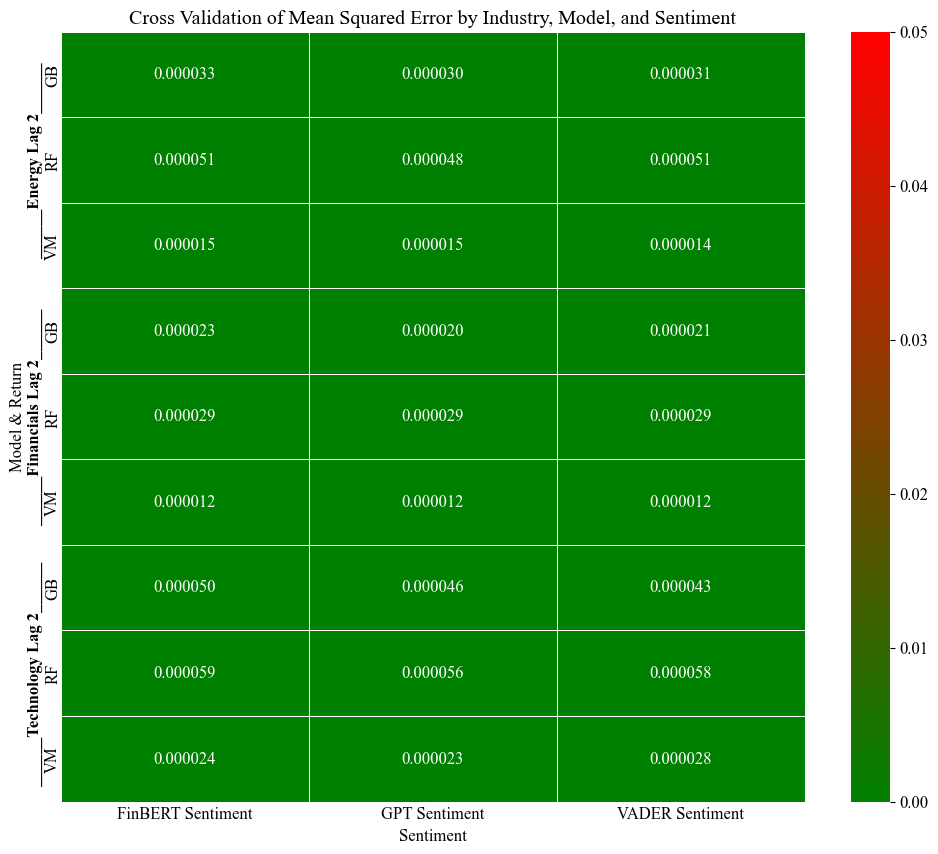

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
# Set the global font to be Times New Roman, size 10
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12


# Read the CSV file
file_path = 'results_lag2.csv'
data = pd.read_csv(file_path)

# Define the models
models = ['RF', 'GB', 'VM']
sentiments = ['VADER Sentiment', 'FinBERT Sentiment', 'GPT Sentiment']

# Create a dictionary to store the results
result_matrix = {'Industry': [], 'Sentiment': [], 'Model': [], 'R2': [], 'MSE': []}

# Iterate through the industries, sentiments, and models
for index, row in data.iterrows():
    industry_lag_value = row['Return(Lag)/Sentiment&Model']
    
    # Skip this row if the value is NaN
    if pd.isna(industry_lag_value):
        continue
    
    industry_lag = str(industry_lag_value).split(' ')
    industry = " ".join(industry_lag[:-2])
    lag = " ".join(industry_lag[-2:])

    for sentiment in sentiments:
        for model in models:
            col_name_r2 = f'{sentiment} {model} R2'
            col_name_mse = f'{sentiment} {model} MSE'
            r2_value = row[col_name_r2]
            mse_value = row[col_name_mse]
            result_matrix['Industry'].append(industry + " " + lag)
            result_matrix['Sentiment'].append(sentiment)
            result_matrix['Model'].append(model)
            result_matrix['R2'].append(r2_value)
            result_matrix['MSE'].append(mse_value)

# Convert the result to a DataFrame and print
result_df = pd.DataFrame(result_matrix)
print(result_df)

# Defining the order of the sectors
sectors_order = ['Energy', 'Financials', 'Technology']
sector_type = CategoricalDtype(categories=sectors_order, ordered=True)
model_sector_df['Sector'] = model_sector_df['Sector'].astype(sector_type)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Remove sharey=True

# Beispiel für ein benutzerdefiniertes Farbschema:
colors = ["#0077BB", "#EE6677", "#228833"]

# Plot the bar plots
for i, model in enumerate(models_full_names):
    subset = model_sector_df[model_sector_df['Model'] == model]
    sns.barplot(x='Sector', y='R2', hue='Sentiment', data=subset, ax=axes[i], order=['Energy', 'Financials', 'Technology'], palette=colors)
    axes[i].set_title(f'{model}')
    axes[i].set_ylim(0, 1)
    axes[i].set_xlabel('Sector')
    axes[i].set_ylabel('R2 Score')  # Set y-label for each subplot
    axes[i].tick_params(axis='x', length=0)  # Remove x-tick marks but retain labels
    axes[i].legend(loc='lower right', title='Sentiment', fontsize='small')

plt.tight_layout()
plt.savefig('Graphics/3 R2_Scores.png')
plt.savefig('Graphics/3 R2_Scores.pdf', bbox_inches='tight')
plt.show()


# Pivot the DataFrame to create a matrix for the heatmap
mse_matrix = result_df.pivot_table(index=['Industry', 'Model'], columns='Sentiment', values='MSE')

# Create a custom color map
custom_cmap = LinearSegmentedColormap.from_list("", ["green", "red"])

# Define the plot
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(mse_matrix, cmap=custom_cmap, annot=True, linewidths=0.5, fmt='.6f', ax=ax, vmin=0, vmax=0.05) # Modify vmin and vmax to fit the MSE range

# Hide the default y-ticks
ax.yaxis.set_ticks([])

# Remove x-tick marks but retain labels
ax.tick_params(axis='x', length=0)

# Define a function to add model labels
def add_model_labels(models, start_pos):
    for i, model in enumerate(models):
        ax.text(-0.03, start_pos + i + 0.5, model, rotation=90, va='center', ha='center')

# Extract the unique industries and models
industries = mse_matrix.index.get_level_values('Industry').unique()
models_repeated = mse_matrix.index.get_level_values('Model')

# Add industry and model labels
start_pos = 0
models_per_industry = len(models)
for industry in industries:
    ax.text(-0.1, start_pos + models_per_industry / 2, f"______{industry}______", rotation=90, va='center', ha='center', weight='bold')
    add_model_labels(models_repeated[start_pos:start_pos + models_per_industry], start_pos)
    start_pos += models_per_industry

# Set x-axis labels
x_labels = mse_matrix.columns.get_level_values('Sentiment')
ax.set_xticklabels(x_labels, rotation=0, ha='center')

# Add y-axis label to the far left
plt.ylabel('Model & Return', labelpad=25)

# Set title and axis labels
plt.title('Cross Validation of Mean Squared Error by Industry, Model, and Sentiment')
plt.xlabel('Sentiment')

# Save the plot
plt.savefig('Graphics/3 MSE_Scores.png')
plt.savefig('Graphics/3 MSE_Scores.pdf', bbox_inches='tight')

plt.show()
